# Part 3

See `assessment.ipynb` for details regarding completing this section.

**NOTE**: When unaltered, this notebook should successfully run. If, in its unedited form you see an error, please check your Devito installation.

### Required imports: Do not edit

In [1]:
import numpy as np
%matplotlib inline

from examples.seismic import Model, AcquisitionGeometry, Receiver, plot_image, plot_velocity, plot_perturbation
from examples.seismic.acoustic import AcousticWaveSolver

import matplotlib.pyplot as plt

from devito import Function, TimeFunction, Eq, Operator, norm, mmax, configuration

configuration['log-level'] = 'WARNING'

### Synthetic model generator

In [2]:
# IMPORTANT: Do not edit this cell
vback = 2.0
vcore = [2.2, 2.4, 2.6, 2.8, 3.0]
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

def ncore(shape, vback, vcore):
    v = np.full(shape, vback)
    rad = 35
    center = []
    for s in shape:
        center.append(int(0.5*(s-1)+1))
    width = np.array(rad, dtype=int)/len(vcore)
    layer = []
    for i in range(len(vcore)):
        layer.append(int(rad-i*width))
    for l, vl in zip(layer, vcore):
        for i in range(shape[0]):
            for j in range(shape[1]):
                if np.sqrt((i-center[0])**2+(j-center[1])**2) < l:
                    v[i,j] = vl
    return v

### FWI and model settings

In [3]:
nshots = 9  # Number of shots to create gradient from
nreceivers = 101  # Number of receiver locations per shot
fwi_iterations = 5  # Number of outer FWI iterations

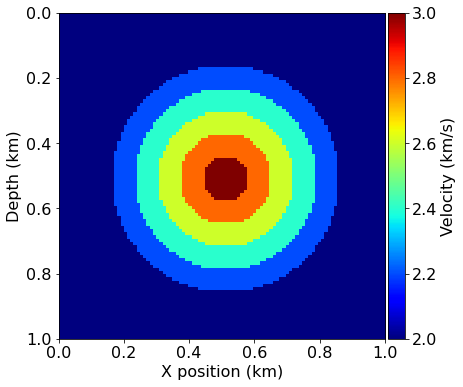

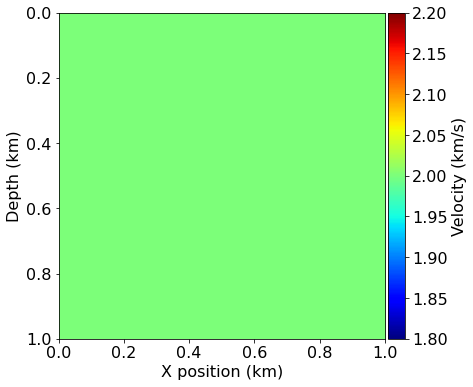

In [4]:
# Define true and initial model

shape = (101, 101)  # Number of grid point (nx, nz)
v = ncore(shape, vback, vcore)
v0 = np.full(shape, vback)

model = Model(vp=v, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

model0 = Model(vp=v0, origin=origin, shape=shape, spacing=spacing,
              space_order=2, nbl=10, bcs="damp")

plot_velocity(model)
plot_velocity(model0)

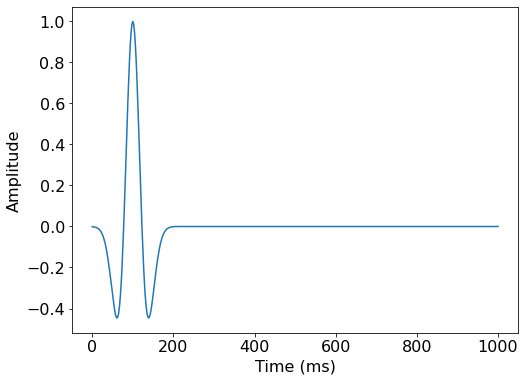

In [5]:
# Define acquisition geometry: source

t0 = 0.
tn = 1000.
f0 = 0.010
# First, position source centrally in all dimensions, then set depth
src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, 0] = 20.  # Depth is 20m

# Define acquisition geometry: receivers

# Initialize receivers for synthetic and imaging data
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 1] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 0] = 980.

# Geometry

geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')
# We can plot the time signature to see the wavelet
geometry.src.show()

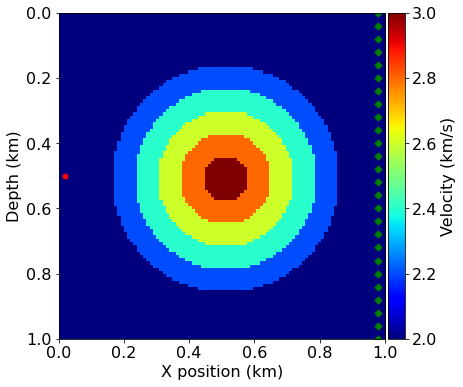

In [6]:
# Plot acquisition geometry
plot_velocity(model, source=geometry.src_positions,
              receiver=geometry.rec_positions[::4, :])

In [7]:
# Create solver
solver = AcousticWaveSolver(model, geometry, space_order=4)

In [8]:
# Prepare the varying source locations sources
source_locations = np.empty((nshots, 2), dtype=np.float32)
source_locations[:, 0] = 30.
source_locations[:, 1] = np.linspace(0., 1000, num=nshots)

In [9]:
# Computes the residual between observed and synthetic data into the residual
def compute_residual(residual, dobs, dsyn):
    residual.data[:] = dsyn.data[:] - dobs.data[:]
    return residual

In [10]:
# Create FWI gradient kernel

def fwi_gradient(vp_in):
    # Create symbols to hold the gradient
    grad = Function(name="grad", grid=model.grid)
    # Create placeholders for the data residual and data
    residual = Receiver(name='residual', grid=model.grid,
                        time_range=geometry.time_axis,
                        coordinates=geometry.rec_positions)
    d_obs = Receiver(name='d_obs', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    d_syn = Receiver(name='d_syn', grid=model.grid,
                     time_range=geometry.time_axis,
                     coordinates=geometry.rec_positions)
    objective = 0.
    for i in range(nshots):
        # Update source location
        geometry.src_positions[0, :] = source_locations[i, :]

        # Generate synthetic data from true model
        _, _, _ = solver.forward(vp=model.vp, rec=d_obs)

        # Compute smooth data and full forward wavefield u0
        _, u0, _ = solver.forward(vp=vp_in, save=True, rec=d_syn)

        # Compute gradient from data residual and update objective function
        compute_residual(residual, d_obs, d_syn)

        objective += .5*norm(residual)**2
        solver.gradient(rec=residual, u=u0, vp=vp_in, grad=grad)

    return objective, grad

In [11]:
# Compute gradient of initial model
ff, update = fwi_gradient(model0.vp)

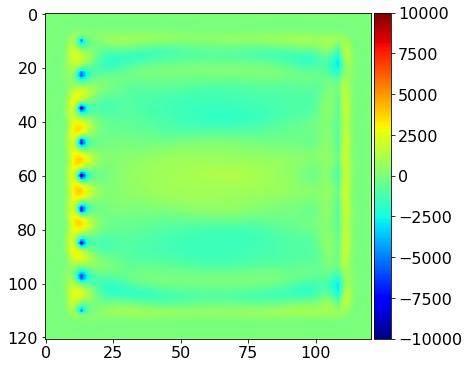

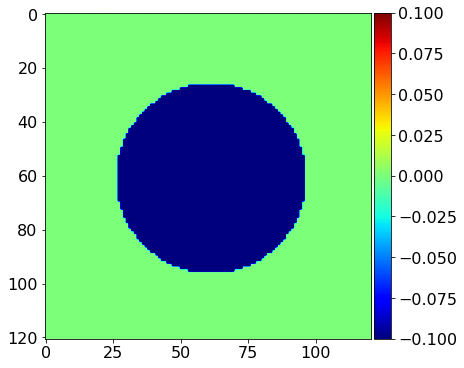

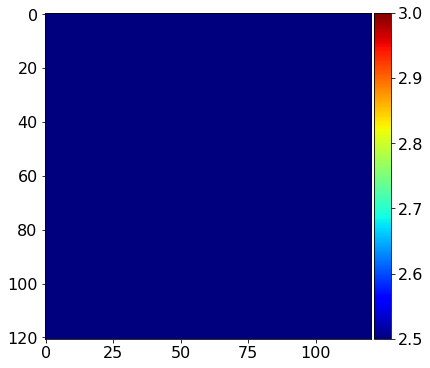

In [12]:
# Plot the FWI gradient
plot_image(-update.data, vmin=-1e4, vmax=1e4, cmap="jet")

# Plot the difference between the true and initial model.
# This is not known in practice as only the initial model is provided.
plot_image(model0.vp.data - model.vp.data, vmin=-1e-1, vmax=1e-1, cmap="jet")

# Show what the update does to the model
alpha = .5 / mmax(update)
plot_image(model0.vp.data + alpha*update.data, vmin=2.5, vmax=3.0, cmap="jet")

In [13]:
from sympy import Min, Max
# Define bounding box constraints on the solution.
def update_with_box(vp, alpha, dm, vmin=2.0, vmax=3.5):
    """
    Apply gradient update in-place to vp with box constraint

    Notes:
    ------
    For more advanced algorithm, one will need to gather the non-distributed
    velocity array to apply constrains and such.
    """
    update = vp + alpha * dm
    update_eq = Eq(vp, Max(Min(update, vmax), vmin))
    Operator(update_eq)()

In [14]:
# Run FWI with gradient descent
history = np.zeros((fwi_iterations, 1))
for i in range(0, fwi_iterations):
    # Compute the functional value and gradient for the current
    # model estimate
    phi, direction = fwi_gradient(model0.vp)

    # Store the history of the functional values
    history[i] = phi

    # Artificial Step length for gradient descent
    # In practice this would be replaced by a Linesearch (Wolfe, ...)
    # that would guarantee functional decrease Phi(m-alpha g) <= epsilon Phi(m)
    # where epsilon is a minimum decrease constant
    alpha = .05 / mmax(direction)

    # Update the model estimate and enforce minimum/maximum values
    update_with_box(model0.vp , alpha , direction)

    # Log the progress made
    print('Objective value is %f at iteration %d' % (phi, i+1))

Objective value is 502887.099791 at iteration 1
Objective value is 494874.514229 at iteration 2
Objective value is 487357.748927 at iteration 3
Objective value is 480268.561582 at iteration 4
Objective value is 473538.338827 at iteration 5


### In editing various sections above, you should see the below results improve.

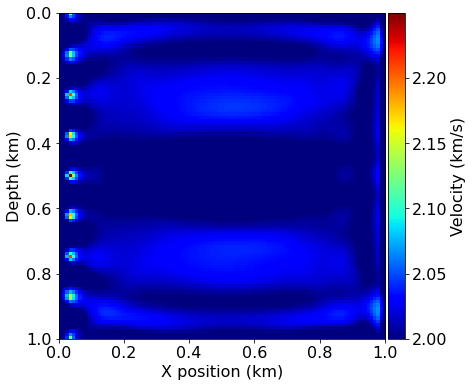

In [15]:
# Plot inverted velocity model
plot_velocity(model0)

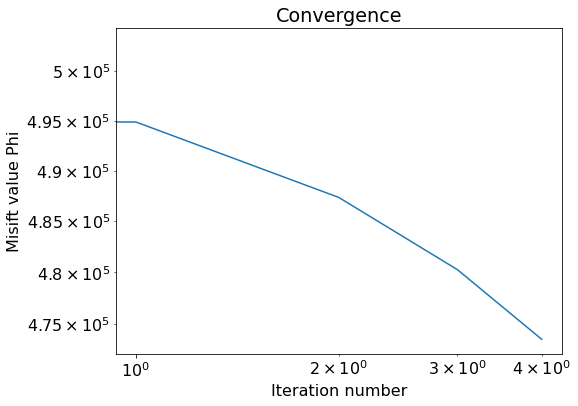

In [16]:
# Plot objective function decrease
plt.figure()
plt.loglog(history)
plt.xlabel('Iteration number')
plt.ylabel('Misift value Phi')
plt.title('Convergence')
plt.show()